# 1. Setup

In [1]:
# Useful starting lines
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Import useful libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import time
from helpers import *

In [2]:
# Define the path to the dataset
data_path = "data/dataset_to_release_2"

# Load data from the specified dataset path
x_train, x_test, y_train, train_ids, test_ids = load_csv_data(data_path)

# 2. Data cleaning

First, let's examine the data's class balance :

In [3]:
# Count the number of occurrences where the value is -1 and 1 in the y_train array :
count_minus_ones = np.count_nonzero(y_train == -1)
count_ones = np.count_nonzero(y_train == 1)

# Get the total number of samples in y_train :
total_samples = len(y_train)

# Calculate the percentage of occurrences of -1 and 1 in the y_train array :
percentage_minus_ones = (count_minus_ones / total_samples) * 100
percentage_ones = (count_ones / total_samples) * 100

# Print the percentage of occurrences of -1 and 1 with two decimal places :
print(f"Percentage of -1 in y_train: {percentage_minus_ones:.2f}%")
print(f"Percentage of 1 in y_train: {percentage_ones:.2f}%")

Percentage of -1 in y_train: 91.17%
Percentage of 1 in y_train: 8.83%


The classes are significantly imbalanced, which suggests that we should prioritize the use of the **F1 score** as a prediction metric, since a model that always output -1 will have an accuracy of 91%.

### First features filtering appraoch : Manual cleaning

Our first approach is to manually examine each feature and subjectively decide if it's relevant to keep it or not.

In [4]:
# Creates a dictionary that maps each feature name to its respective column index :
with open('data/dataset_to_release_2/x_train.csv', 'r') as f:
    column = f.readline().split(',')
    column[-1] = column[-1][:-1]
    column_dict = {column[1:][i]: i for i in range(len(column[1:]))}

In [5]:
# Given the dictionary that maps each feature name to its respective column index, and the target columns, return the target indexes.
def get_indexes_by_features_name(feature_dict, keys):
    values = []
    for key in keys:
        if key in feature_dict:
            values.append(feature_dict[key])
    return values

In [6]:
# Create a copy of each array to avoid modifying the original data :
x_train_cleaned_manual = x_train.copy()
x_test_cleaned_manual = x_test.copy()

# Define a list of column names (or keys) that represent continuous variables to be retained :
continuous_keeped = ['GENHLTH','_AGE80','_AGEG5YR','_AGE_G','_AGE65YR','ARTTODAY','CHILDREN','LASTPAP2','ACTIN11_','CDASSIST',
                     'ADMOVE','PHYSHLTH','_CHLDCNT','CDHOUSE','ALCDAY5','EDUCA','VIDFCLT2','_EDUCAG','LENGEXAM','CHOLCHK']

# Define a list of column names (or keys) that represent category variables to be retained :
category_keeped = ['SEX','MEDCOST','CVDCRHD4','CVDSTRK3','CHCOCNCR','CHCCOPD1','HAVARTH3', 'ADDEPEV2','SMOKE100','EXERANY2',
                   'HPVADVC2','SHINGLE2','PREDIAB1','INSULIN','CDDISCUS','DRADVISE','ASATTACK','HAREHAB1','STREHAB1','RDUCHART',
                   'ARTHWGT','_RFHLTH','_RFHYPE5','_RFCHOL','_LTASTH1','_RFBMI5','_RFDRHV5','_LMTACT1','_PNEUMO2','_AIDTST3']

# Combine the two lists to create a single list of keys/columns to be retained :
keys_to_lookup = continuous_keeped + category_keeped

# Fetch the indices of the desired columns using the get_values function and the column_dict dictionary :
selected_columns_indexes = get_indexes_by_features_name(column_dict, keys_to_lookup)

# Filter and retain only the desired columns in the x arrays using the obtained indices :
x_train_cleaned_manual = x_train_cleaned_manual[:, selected_columns_indexes]
x_test_cleaned_manual = x_test_cleaned_manual[:, selected_columns_indexes]

In [7]:
print(f"x_train went from {x_train.shape[1]} features to {x_train_cleaned_manual.shape[1]} features")
print(f"x_test went from {x_test.shape[1]} features to {x_test_cleaned_manual.shape[1]} features")

x_train went from 321 features to 49 features
x_test went from 321 features to 49 features


Unfortunatelly, after training our model with such manual cleaning, we couldn't exceed a F1 score of 38%.

### Second features filtering appraoch : Statistical cleaning

Our second approach is to filter the features with some basic statistics. We remove the columns that have too many missing data (null values). Then we remove the constant columns.

In [8]:
# Create a copy of each array to avoid modifying the original data :
x_train_cleaned = x_train.copy()
x_test_cleaned = x_test.copy()

# Calculate the fraction of NaN values for each column
nan_fraction_train = np.isnan(x_train_cleaned).mean(axis=0)

# Use the mask to filter out columns with more than 80% NaN values
mask_null = nan_fraction_train < 0.8
x_train_cleaned = x_train_cleaned[:, mask_null]
x_test_cleaned = x_test_cleaned[:, mask_null]

In [9]:
# Identify non-constant columns, columns that have a standard deviation not equal to zero :
mask_variance = (np.nanstd(x_train_cleaned, axis=0) != 0.0)

# Retain only the non-constant columns in the x_train_copied dataset :
x_train_cleaned = x_train_cleaned[:, mask_variance]
x_test_cleaned = x_test_cleaned[:, mask_variance]

In [10]:
print(f"x_train went from {x_train.shape[1]} features to {x_train_cleaned.shape[1]} features")
print(f"x_test went from {x_test.shape[1]} features to {x_test_cleaned.shape[1]} features")

x_train went from 321 features to 201 features
x_test went from 321 features to 201 features


This cleaning allowed us to achieve a higher F1 score. Therefore we will use it instead of the manual one.

### Filling missing values

In [11]:
# For each element in x arrays, if the element is NaN, replace it with the median :
x_train_cleaned = np.where(np.isnan(x_train_cleaned), np.nanmedian(x_train_cleaned, axis=0), x_train_cleaned)
x_test_cleaned = np.where(np.isnan(x_test_cleaned), np.nanmedian(x_test_cleaned, axis=0), x_test_cleaned)

In [12]:
x_train_cleaned_nan_count = np.isnan(x_train_cleaned).sum()
x_test_cleaned_nan_count = np.isnan(x_test_cleaned).sum()

assert x_train_cleaned_nan_count == 0, f"Unexpected number of NaN values in x_train_cleaned: {x_train_cleaned_nan_count}"
assert x_test_cleaned_nan_count == 0, f"Unexpected number of NaN values in x_test_cleaned: {x_test_cleaned_nan_count}"

print(f"Number of NaN values in x_train_cleaned: {x_train_cleaned_nan_count}")
print(f"Number of NaN values in x_test_cleaned: {x_test_cleaned_nan_count}")

Number of NaN values in x_train_cleaned: 0
Number of NaN values in x_test_cleaned: 0


# 3. Useful functions

**Standardize**

The `standardize` function is designed to standardize an original dataset. It scales the data to have a mean of 0 and a standard deviation of 1.

In [13]:
def standardize(x):
    mean_x = np.mean(x, axis=0)
    x = x - mean_x
    std_x = np.std(x, axis=0)
    x = x / std_x
    return x, mean_x, std_x

**Split data**

The `split_data` function is designed to split a dataset into training and testing sets.

In [14]:
def split_data(x, y, ratio, seed=1):
    # set seed
    np.random.seed(seed)

    N = len(y)
    indices = np.random.permutation(N)
        
    split = int(np.floor(N*ratio))
    indice_train = indices[:split]
    indice_test = indices[split:]
    
    x_train = x[indice_train]
    y_train = y[indice_train]
    x_test = x[indice_test]
    y_test = y[indice_test]
    
    return x_train, x_test, y_train, y_test

**Evaluation metrics**

- `accuracy` Function: Calculates the accuracy of a classification model by comparing predicted labels to ground truth labels.

- `calculate_f1_score` Function: Computes the F1 score, a balanced metric for assessing the performance of binary classification models using precision and recall.

In [15]:
def calculate_accuracy(gt_values, preds):
    return np.mean(preds == gt_values.reshape(-1, 1))

In [25]:
def calculate_f1_score(predicted, true):
    true_positives = sum(p == 1 and t == 1 for p, t in zip(predicted, true))
    false_positives = sum(p == 1 and t == -1 for p, t in zip(predicted, true))
    false_negatives = sum(p == -1 and t == 1 for p, t in zip(predicted, true))

    if true_positives == 0:
        return 0  # Handle the case where there are no true positives to avoid division by zero.

    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)

    f1 = 2 * (precision * recall) / (precision + recall)
    return f1[0]

# 4. Classification models

We standardize the training and testing datasets `x_train_cleaned` and `x_test_cleaned`.

In [18]:
x_train_cleaned, _, _ = standardize(x_train_cleaned)
x_test_cleaned, _, _ = standardize(x_test_cleaned)

We split the cleaned training data `x_train_cleaned` and corresponding labels `y_train_cleaned` into training and validation sets.

In [19]:
x_train_set, x_validation_set, y_train_set, y_validation_set = split_data(x_train_cleaned, y_train, 0.8)

### A. Least Squares for classification

We will try the Least Squares method, using the **Mean Squared Error (MSE)** as the loss function.

We start by defining useful functions :

In [40]:
# Calculate the least squares solution.
def least_squares(y, tx):
    A = tx.T.dot(tx)
    B = tx.T.dot(y)
    w, _, _, _ = np.linalg.lstsq(A, B, rcond=None)
    mse = compute_loss(y, tx, w)
    
    return (w, mse)

# Calculate the mse loss
def compute_loss(y, tx, w):
    e = y - tx.dot(w)
    mse = 1 / 2 * np.mean(e**2)
    
    # We can also test it with the MAE loss function.
    # mae = np.mean(abs(e))
    return mse

Now we will train our model and try to find the best decision threshold that maximizes the F1 score :

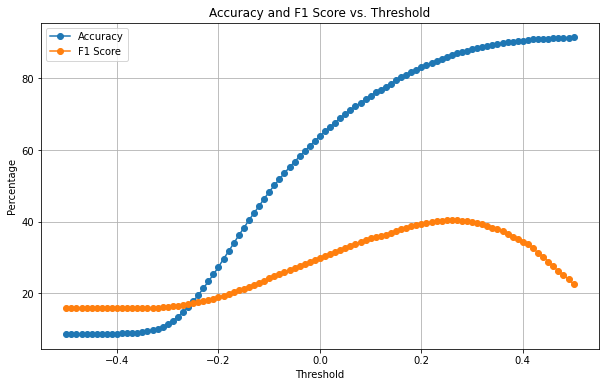

In [27]:
# Define the thresholds to test
thresholds = np.arange(-0.5, 0.51, 0.01)

# Initialize empty lists to store accuracy and F1 scores
accuracies = []
f1_scores = []

w, loss = least_squares(y_train_set.reshape(-1, 1), x_train_set)
predictions = x_validation_set @ w

# Loop through each threshold
for threshold in thresholds:
    preds = np.where(predictions >= threshold, 1, -1)
    accuracy = calculate_accuracy(y_validation_set.reshape(-1, 1), preds) * 100
    f1_score = calculate_f1_score(preds, y_validation_set)*100

    accuracies.append(accuracy)
    f1_scores.append(f1_score)

# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(thresholds, accuracies, label='Accuracy', marker='o')
plt.plot(thresholds, f1_scores, label='F1 Score', marker='o')
plt.xlabel('Threshold')
plt.ylabel('Percentage')
plt.title('Accuracy and F1 Score vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()

Since we are interested in the F1 score, we can notice that it's maximized for `threshold` = 0.265

In [57]:
start_time = time.time()
w, loss = least_squares(y_train_set.reshape(-1, 1), x_train_set)
end_time = time.time()
elapsed_time = end_time - start_time

# Make predictions
predictions = x_validation_set @ w

threshold = 0.265

# Apply a threshold to get binary class labels (e.g., 0 as the threshold)
preds = np.where(predictions >= threshold, 1, -1)
accuracy = calculate_accuracy(y_validation_set.reshape(-1, 1), preds) * 100
f1_score = calculate_f1_score(preds, y_validation_set)*100

print(f"Best threshold: {threshold}")
print(f"Accuracy: {accuracy:.2f}%")
print(f"F1 score: {f1_score:.2f}%")
print(f"Time taken: {elapsed_time:.2f} sec")

Best threshold: 0.265
Accuracy: 86.71%
F1 score: 40.55%
Time taken: 0.37 sec


The scores seems good, and the algorithm is very performant (0.37 sec).

Furthermore, testing it with the **Mean Absolute Error (MAE)** gives the exact same result

Let's see if the Logistic Regression approach gives better results.

### B. Logistic Regression

We start by defining the functions used for logistic regression, with `sigmoid` computing the sigmoid function, `compute_loss_log_reg` calculating the negative log likelihood loss, and `compute_gradient_log_reg` computing the gradient of the loss.

In [60]:
# Apply sigmoid function on t.
def sigmoid(t):
    return 1.0 / (1 + np.exp(-t))

# Computes the cost by negative log likelihood.
def compute_loss_log_reg(y, tx, w):
    assert y.shape[0] == tx.shape[0]
    assert tx.shape[1] == w.shape[0]
    
    pred = sigmoid(tx.dot(w))
    loss = y.T.dot(np.log(pred)) + (1 - y).T.dot(np.log(1 - pred))
    
    return np.squeeze(-loss).item() * (1 / y.shape[0])

# Computes the gradient of loss.
def compute_gradient_log_reg(y, tx, w):
    pred = sigmoid(tx.dot(w))
    grad = tx.T.dot(pred - y) * (1 / y.shape[0])
    
    return grad

The `logistic_regression` function performs logistic regression using the gradient descent algorithm to find model parameters `w` and associated `loss` given input data `y`, `tx`, an initial guess `initial_w`, a maximum number of iterations `max_iters`, and a step size `gamma`.

In [61]:
def logistic_regression(y, tx, initial_w, max_iters, gamma):
    w = initial_w
    loss = 0
    
    for n_iter in range(max_iters):
        gradient = compute_gradient_log_reg(y, tx, w)
        w = w - gamma * gradient
        loss = compute_loss_log_reg(y, tx, w)
    
    return w, loss

This function, `logistic_regression_classify`, uses logistic regression to classify data into binary categories based on the provided model parameters w and a specified threshold, returning the predicted binary labels as integers.

In [62]:
def logistic_regression_classify(data, w, threshold):

    predictions = sigmoid(data @ w)
        
    predictions[predictions <= threshold] = -1
    predictions[predictions > threshold] = 1
     
    return predictions.astype(int)

Now we can train our Logistic Regression model. We will start by finding the best decision threshold, and then the best hyperparameters.

**Find the best Decision threshold**

In [63]:
# Train our model with arbitrary max_iters and gamma
initial_w = np.zeros((x_train_set.shape[1], 1))
max_iters = 1000
gamma = 0.25

w, loss = logistic_regression(y_train_set.reshape(-1, 1), x_train_set, initial_w, max_iters, gamma)

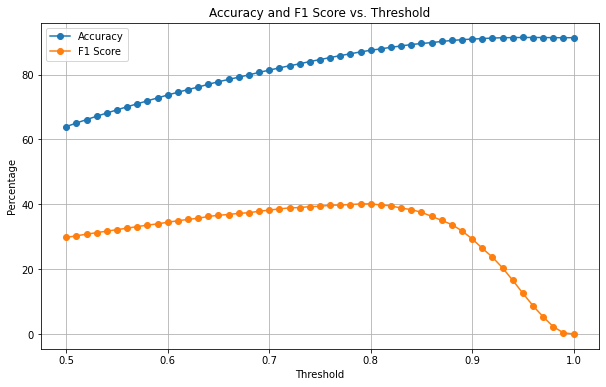

In [65]:
# Define the thresholds to test
thresholds = np.arange(0.5, 1.01, 0.01)

# Initialize empty lists to store accuracy and F1 scores
accuracies = []
f1_scores = []

# Loop through each threshold
for threshold in thresholds:
    preds = logistic_regression_classify(x_validation_set, w, threshold)
    accuracy = calculate_accuracy(y_validation_set.reshape(-1, 1), preds) * 100
    f1_score = calculate_f1_score(preds, y_validation_set) * 100

    accuracies.append(accuracy)
    f1_scores.append(f1_score)

# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(thresholds, accuracies, label='Accuracy', marker='o')
plt.plot(thresholds, f1_scores, label='F1 Score', marker='o')
plt.xlabel('Threshold')
plt.ylabel('Percentage')
plt.title('Accuracy and F1 Score vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()

Since we are interested in the F1 score, we can notice that it's maximized for `treshold` = 0.8

In [68]:
# Calculate accuracy
threshold = 0.8
preds = logistic_regression_classify(x_validation_set, w, threshold)
accuracy = calculate_accuracy(y_validation_set.reshape(-1, 1), preds) * 100
f1_score = calculate_f1_score(preds, y_validation_set) * 100

print(f"Best threshold: {threshold}")
print(f"Accuracy: {accuracy:.2f}%")
print(f"F1 score: {f1_score:.2f}%")

Best threshold: 0.8
Accuracy: 87.49%
F1 score: 40.13%


**Now we will try to find the best hyperparameters `gamma`and `max_iters_values`**

Given a `gamma`, the Gradient Decent algorithm needs enough time (iterations) to converge. Therefore, we will analyze results for `gamma`and `max_iters_values` simultanously to find a good tradeoff with the performances.

**Training :**

<span style="color:red">**Warning:** The following cell takes some time to run (10 min) since its purpose is to train the model 15 times with multiple `max_iters_values` with multiple `gamma`.</span>

In [69]:
# Define lists of gamma and max_iters values to test
gamma_values = [0.005, 0.01, 0.1, 0.25, 0.5]
max_iters_values = [100, 500, 1000]

results = []

for gamma in gamma_values:
    for max_iters in max_iters_values:
        start_time = time.time()
        w, loss = logistic_regression(y_train_set.reshape(-1, 1), x_train_set, initial_w, max_iters, gamma)
        end_time = time.time()
        elapsed_time = end_time - start_time
        results.append((gamma, max_iters, w, loss, elapsed_time))

**Visualization :**

In [71]:
# Sort the results by loss in ascending order (Index 3 corresponds to the loss value)
sorted_results = sorted(results, key=lambda x: x[3])

table_results = [["Gamma", "Max iter", "F1 score", "Accuracy", "Time taken (sec)"]]

for gamma, max_iters, w, loss, elapsed_time in sorted_results:
    preds = logistic_regression_classify(x_validation_set, w, threshold)
    accuracy = calculate_accuracy(y_validation_set.reshape(-1, 1), preds) * 100
    f1_score = calculate_f1_score(preds, y_validation_set) * 100
    table_results.append([gamma, max_iters, f"{f1_score:.2f}", f"{accuracy:.2f}", f"{elapsed_time:.2f}"])

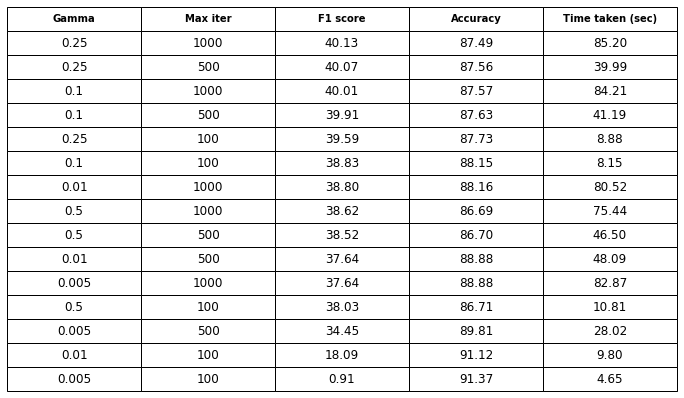

In [72]:
# Create a figure and axis for the table
fig, ax = plt.subplots()

# Create the table
table = ax.table(cellText=table_results, loc='center', cellLoc='center')

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(2, 2)  # Adjust the size as needed

# Make the header text bold
font = FontProperties()
font.set_weight('bold')
for (i, j), cell in table._cells.items():
    if i == 0:
        cell.set_text_props(fontproperties=font)

# Remove the axis
ax.axis('off')

# Display the table
plt.show()

Results are sorted in ascending order of loss. We can notice an excellent tradeoff between result and performance (5rd line) :

- Gamma: 0.25, Max Iter: 100
- F1 Score: 39.59, Accuracy: 87.73, 
- Time Taken: 8.88 seconds

### C. Regularized Ridge Logistic Regression

Now we will try the Regularized Ridge Logistic Regression algorithm. The regularization term helps prevent overfitting by penalizing large parameter values.

In [73]:
# Computes Regularized Logistic Regression using Gradient Descent Algorithm.
def reg_logistic_regression(y, tx, lambda_, initial_w, max_iters, gamma):        
    w = initial_w
    loss = 0
    for n_iter in range(max_iters):
        gradient = compute_gradient_log_reg(y, tx, w) + 2*lambda_*w
        w = w - gamma * gradient
        loss = compute_loss_log_reg(y, tx, w) + lambda_ * np.squeeze(w.T.dot(w))

    return w, loss

We will try to find the best regularization term `lambda_`. For that we will use the optimized (in term of performances) `gamma` and `max_iters_values` previouly found

In [74]:
# Define your data and parameters
initial_w = np.zeros((x_train_set.shape[1], 1))
max_iters = 100
gamma = 0.25

# Define a list of alpha values to test
lambdas_values = [0.001, 0.005, 0.01, 0.1]

results_reg = []

for l in lambdas_values:
    w, loss = reg_logistic_regression(y_train_set.reshape(-1, 1), x_train_set, l, initial_w, max_iters, gamma)
    results_reg.append((l, w, loss))

In [76]:
# Display or analyze the results for each alpha value
for alpha, w, loss in results_reg:
    preds = logistic_regression_classify(x_validation_set, w, threshold)
    accuracy = calculate_accuracy(y_validation_set.reshape(-1, 1), preds) * 100
    f1_score = calculate_f1_score(preds, y_validation_set) * 100
    print(f"Alpha: {alpha}, F1 Score: {f1_score:.2f}, Accuracy: {accuracy:.2f}")

Alpha: 0.001, F1 Score: 39.52, Accuracy: 87.76
Alpha: 0.005, F1 Score: 39.37, Accuracy: 87.95
Alpha: 0.01, F1 Score: 39.13, Accuracy: 88.18
Alpha: 0.1, F1 Score: 32.87, Accuracy: 90.23


We notice that the Regularized Logistic Regression and the regular Logistic Regression give us comparable results. Actually, the lower is the regularizer, the more precise is the algorithm. Therefore, we conclude that we don't need regularization.

# 5. Conclusion and Final submission

To conclude, our best algorithm is the Least Squares method for classification. Not only in scores, byt also in performances :

- Accuracy: 86.71%
- F1 score: 40.55%
- Time taken: 0.37 sec

Regarding the Logistic Regression. The best **tradeoff** between **score** and **performance** is the following :

- **Gamma: 0.25, Max Iter: 100**
- Accuracy: 87.73%
- F1 Score: 39.59%
- Time Taken: 10.56 seconds

But if we don't take the performances into account, we can achieve a better score :

- **Gamma: 0.25, Max Iters: 1000**
- Accuracy: 87.49%
- F1 Score: 40.13%
- Time Taken: 85.20 seconds

# 6. Comparison and interpretation with external libraries

Finally, please refer to the `comparison.ipynb` file to see the comparison of our Logistic Regression model with sklearn Logitic Regression model.

We have put this comparison in completely separate file, to make clear our own code has no dependencies.